# Package Imports

In [1]:
#############################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import warnings
warnings.filterwarnings('ignore')
from collections import Counter
from wordcloud import WordCloud
#############################################
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
#############################################
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer 
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag

# 1. Data Import & Basic Cleaning

In [2]:
# import the data from the csv file
df = pd.read_csv('./projectdata.csv', encoding='latin-1')
df.head()
# Drop the review_id column
df = df.drop(['review_id'], axis=1)
# Drop the review_author column
df = df.drop(['review_author'], axis=1)
# Drop the review_title column
df = df.drop(['review_title'], axis=1)
# Drop the review_date column
df = df.drop(['review_date'], axis=1)
df.head()

,movie_id,movie_title,review_rating,review_text,review_helpfulness_upvote,review_helpfulness_total
0,tt0050083,12 Angry Men,NaN,This once-in-a-generation masterpiece simply h...,321,358
1,tt0050083,12 Angry Men,NaN,This film deserves to be on anyone's list of t...,355,411
2,tt0050083,12 Angry Men,NaN,Intense courtroom drama which has 12 very diff...,246,282
3,tt0050083,12 Angry Men,10.0,Theater at its best is practically impossible ...,42,46
4,tt0050083,12 Angry Men,10.0,For a while I was not very receptive to watchi...,206,214


In [3]:
# Rename the column names for easier access
df.rename(columns={'movie_id': 'movID', 'movie_title': 'movName', 'review_rating': 'rating', 'review_text': 'text', 'review_helpfulness_upvote': 'upvote', 'review_helpfulness_total': 'totalVotes'}, inplace=True)
# Remove tt from the movID column
df['movID'] = df['movID'].str.replace('tt', '')
# Change the datatype of the movID column to int
df['movID'] = df['movID'].astype(int)
# Change the upvote column to int
df['upvote'] = df['upvote'].str.replace(',', '')
df['upvote'] = df['upvote'].astype(int)
# Change the totalVotes column to int
df['totalVotes'] = df['totalVotes'].str.replace(',', '')
df['totalVotes'] = df['totalVotes'].astype(int)
# Remove the instance where the total votes is 0
df = df[df.totalVotes != 0]
df.shape
df.head()

,movID,movName,rating,text,upvote,totalVotes
0,50083,12 Angry Men,NaN,This once-in-a-generation masterpiece simply h...,321,358
1,50083,12 Angry Men,NaN,This film deserves to be on anyone's list of t...,355,411
2,50083,12 Angry Men,NaN,Intense courtroom drama which has 12 very diff...,246,282
3,50083,12 Angry Men,10.0,Theater at its best is practically impossible ...,42,46
4,50083,12 Angry Men,10.0,For a while I was not very receptive to watchi...,206,214


In [4]:
# Give the movie with the most reviews
print(df['movID'].value_counts().head(1))
print(df['movName'].value_counts().head(1))

7286456    11067
Name: movID, dtype: int64
Joker    11067
Name: movName, dtype: int64


In [5]:
# Create the subset of the data with the movie with the most reviews for implementation
sample = df[df.movID == 7286456]
print(sample.shape)

(11067, 6)


In [6]:
# Creat the helpfulness column
sample['helpfulness'] = sample['upvote'] / sample['totalVotes']
# Drop the upvote column
sample = sample.drop(['upvote'], axis=1)
# Drop the totalVotes column
sample = sample.drop(['totalVotes'], axis=1)

In [7]:
sample.reset_index(drop=True, inplace=True)
sample.head()

,movID,movName,rating,text,helpfulness
0,7286456,Joker,7.0,There is no doubt that the movie was well thou...,0.682359
1,7286456,Joker,9.0,The movie affects you in a way that makes it p...,0.666667
2,7286456,Joker,7.0,When I heard everyone saying that this is the ...,0.638493
3,7286456,Joker,10.0,"Truly a masterpiece, The Best Hollywood film o...",0.771675
4,7286456,Joker,10.0,I have seen Joker yesterday at Venice an early...,0.727982


In [8]:
# Count the NAN values in the sample
sample.isnull().sum()
sample['rating'].fillna(sample['rating'].mean(), inplace=True)
sample.isnull().sum()

movID          0
movName        0
rating         0
text           0
helpfulness    0
dtype: int64

<Axes: xlabel='helpfulness'>

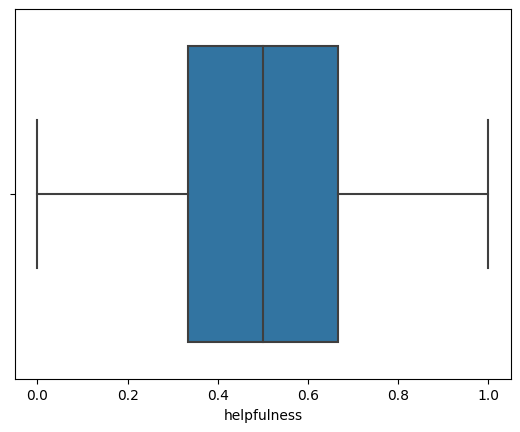

In [9]:
# Box plot of the helpfulness column
sns.boxplot(x=sample['helpfulness'])

In [10]:
# Create a new column helpful for the helpfulness column
sample['helpful'] = sample['helpfulness'].apply(lambda x: 1 if x > sample['helpfulness'].mean() else 0)
# Drop the helpfulness column
sample = sample.drop(['helpfulness'], axis=1)

In [11]:
# Create a new column for the length of the text
sample['textlen'] = sample['text'].apply(len)
# Count sentence number for each review
sample['sentnum'] = sample['text'].apply(lambda x: len(sent_tokenize(x)))
sample.head()

,movID,movName,rating,text,helpful,textlen,sentnum
0,7286456,Joker,7.0,There is no doubt that the movie was well thou...,1,1935,19
1,7286456,Joker,9.0,The movie affects you in a way that makes it p...,1,97,1
2,7286456,Joker,7.0,When I heard everyone saying that this is the ...,1,782,9
3,7286456,Joker,10.0,"Truly a masterpiece, The Best Hollywood film o...",1,862,9
4,7286456,Joker,10.0,I have seen Joker yesterday at Venice an early...,1,1599,8


In [12]:
sample.head()

,movID,movName,rating,text,helpful,textlen,sentnum
0,7286456,Joker,7.0,There is no doubt that the movie was well thou...,1,1935,19
1,7286456,Joker,9.0,The movie affects you in a way that makes it p...,1,97,1
2,7286456,Joker,7.0,When I heard everyone saying that this is the ...,1,782,9
3,7286456,Joker,10.0,"Truly a masterpiece, The Best Hollywood film o...",1,862,9
4,7286456,Joker,10.0,I have seen Joker yesterday at Venice an early...,1,1599,8


In [13]:
# Count the number of helpful and nonhelpful reviews
sample['helpful'].value_counts()

0    6666
1    4401
Name: helpful, dtype: int64

In [14]:
sample.head()

,movID,movName,rating,text,helpful,textlen,sentnum
0,7286456,Joker,7.0,There is no doubt that the movie was well thou...,1,1935,19
1,7286456,Joker,9.0,The movie affects you in a way that makes it p...,1,97,1
2,7286456,Joker,7.0,When I heard everyone saying that this is the ...,1,782,9
3,7286456,Joker,10.0,"Truly a masterpiece, The Best Hollywood film o...",1,862,9
4,7286456,Joker,10.0,I have seen Joker yesterday at Venice an early...,1,1599,8


In [15]:
# Assign text to X and helpful to y
X = sample['text']
y = sample['helpful']

# LDA Clustering For Numerical Data Frame Formation

In [16]:
# Topic Modeling use LDA for creating the Topic labels
stop = list(stopwords.words('english'))
tf_vectorizer = CountVectorizer(min_df=5, stop_words=stop)
tf = tf_vectorizer.fit_transform(X)
tf_feature_names = tf_vectorizer.get_feature_names_out()
lda = LatentDirichletAllocation(n_components=4, \
                                max_iter=40, \
                                learning_method='online', \
                                learning_offset=50., \
                                random_state=0).fit(tf)

# Print the top words for each topic
num_top_words=20
for topic_idx, topic in enumerate(lda.components_):
    print ("Topic %d:" % (topic_idx))
    # print out top 20 words per topic 
    words=[(tf_feature_names[i],'%.2f'%topic[i]) \
           for i in topic.argsort()[::-1][0:num_top_words]]
    print(words)
    print("\n")

Topic 0:
[('arthur', '2841.84'), ('film', '1926.20'), ('joker', '1558.88'), ('fleck', '1289.71'), ('society', '1047.59'), ('phoenix', '849.19'), ('gotham', '787.64'), ('mental', '662.19'), ('city', '651.41'), ('clown', '648.53'), ('character', '633.43'), ('phillips', '592.80'), ('one', '580.84'), ('man', '573.74'), ('world', '557.27'), ('life', '471.79'), ('todd', '467.96'), ('violence', '449.89'), ('mother', '432.12'), ('social', '414.19')]


Topic 1:
[('joker', '7878.80'), ('movie', '6563.73'), ('film', '3313.41'), ('like', '3290.50'), ('people', '2737.03'), ('character', '2410.32'), ('story', '2162.03'), ('really', '1937.31'), ('one', '1914.78'), ('would', '1809.97'), ('batman', '1791.63'), ('see', '1618.57'), ('even', '1512.50'), ('way', '1505.35'), ('think', '1492.46'), ('good', '1456.37'), ('feel', '1356.01'), ('make', '1324.58'), ('much', '1274.82'), ('could', '1267.54')]


Topic 2:
[('movie', '6415.87'), ('phoenix', '4571.25'), ('joaquin', '4218.62'), ('joker', '4142.58'), ('fi

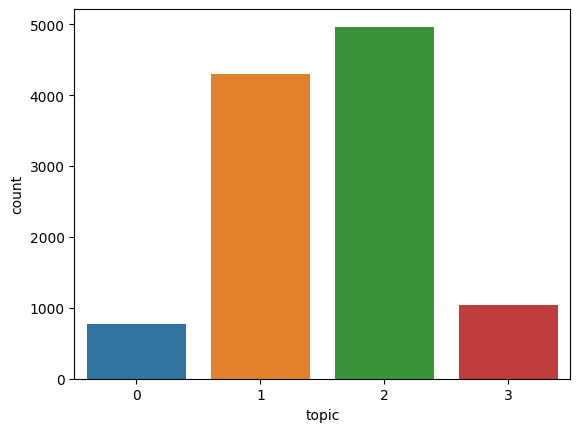

In [17]:
# Predict the topic for each review and append label to the sample
topic_prediction = lda.transform(tf)
sample['topic'] = topic_prediction.argmax(axis=1)
sample.head()
plot = sns.countplot(x='topic', data=sample)


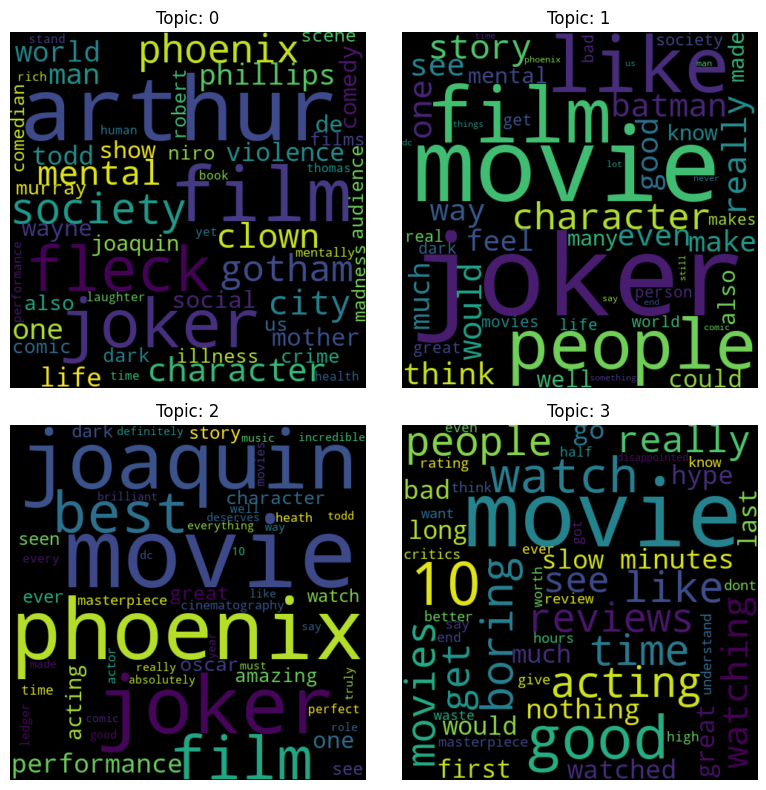

In [18]:
# Print the world cloud for each topic
import math
num_top_words = 50
f, axarr = plt.subplots(2, 2, figsize=(8, 8))
for topic_idx, topic in enumerate(lda.components_):
    f={tf_feature_names[i]:topic[i] for i in topic.argsort()[::-1][0:num_top_words]}
    wordcloud = WordCloud(width=480, height=480, margin=0, background_color = 'black')
    _ = wordcloud.generate_from_frequencies(frequencies=f)
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].imshow(wordcloud, interpolation="bilinear");
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].set_title("Topic: "+str(topic_idx));
    _ = axarr[math.floor(topic_idx/2), topic_idx%2].axis('off')
plt.tight_layout()
plt.show()

# Text Preprocessing

In [19]:
# Text Preprocessing
# Remove the punctuation from the text and set it to lower case
def remove_punctuation(text):
    no_punc = "".join([c for c in text if c not in string.punctuation])
    return no_punc
X = X.apply(lambda x: remove_punctuation(x))
X = X.str.lower()
print(X.head())

0    there is no doubt that the movie was well thou...
1    the movie affects you in a way that makes it p...
2    when i heard everyone saying that this is the ...
3    truly a masterpiece the best hollywood film of...
4    i have seen joker yesterday at venice an early...
Name: text, dtype: object


In [20]:
# Remove the stop words from the text using the nltk stopwords
stop = list(stopwords.words('english'))
X_clean = X.apply(lambda x: " ".join([word for word in x.split() if word not in (stop)]))
print(X_clean.head())

0    doubt movie well thought plot execution must p...
1    movie affects way makes physically painful exp...
2    heard everyone saying film year reviews floodi...
3    truly masterpiece best hollywood film 2019 one...
4    seen joker yesterday venice early illfated scr...
Name: text, dtype: object


In [21]:
# Lemmatize the text
lemmatizer = WordNetLemmatizer()
X_lemma = X_clean.apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
print(X_lemma.head())


0    doubt movie well thought plot execution must p...
1    movie affect way make physically painful exper...
2    heard everyone saying film year review floodin...
3    truly masterpiece best hollywood film 2019 one...
4    seen joker yesterday venice early illfated scr...
Name: text, dtype: object


In [22]:
# Stemmize the text
stemmer = SnowballStemmer("english")
X_stem = X_lemma.apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
print(X_stem.head())

0    doubt movi well thought plot execut must prais...
1     movi affect way make physic pain experi good way
2    heard everyon say film year review flood 10 qu...
3    truli masterpiec best hollywood film 2019 one ...
4    seen joker yesterday venic earli illfat screen...
Name: text, dtype: object


# Text Numerical Feature Extraction

In [23]:
# Use pos tagging to count the number of nouns and adjectives in each review
def count_pos(text):
    pos = pos_tag(word_tokenize(text))
    count = Counter(tag for word, tag in pos)
    noun = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adv = count['RB'] + count['RBR'] + count['RBS']
    adj = count['JJ'] + count['JJR'] + count['JJS']
    return noun, adv, adj

X_pos = X_clean.apply(lambda x: count_pos(x))
X_pos = pd.DataFrame(X_pos.tolist(), columns=['noun', 'adv', 'adj'])

In [24]:
# Append the pos columns to the sample
sample = pd.concat([sample, X_pos], axis=1)
sample.head()

,movID,movName,rating,text,helpful,textlen,sentnum,topic,noun,adv,adj
0,7286456,Joker,7.0,There is no doubt that the movie was well thou...,1,1935,19,1,69,19,37
1,7286456,Joker,9.0,The movie affects you in a way that makes it p...,1,97,1,2,4,1,2
2,7286456,Joker,7.0,When I heard everyone saying that this is the ...,1,782,9,2,24,8,14
3,7286456,Joker,10.0,"Truly a masterpiece, The Best Hollywood film o...",1,862,9,1,34,5,18
4,7286456,Joker,10.0,I have seen Joker yesterday at Venice an early...,1,1599,8,0,56,18,36


In [25]:
# Drop movie name and movie ID
sample = sample.drop(['movName'], axis=1)
sample = sample.drop(['movID'], axis=1)
sample.head()


,rating,text,helpful,textlen,sentnum,topic,noun,adv,adj
0,7.0,There is no doubt that the movie was well thou...,1,1935,19,1,69,19,37
1,9.0,The movie affects you in a way that makes it p...,1,97,1,2,4,1,2
2,7.0,When I heard everyone saying that this is the ...,1,782,9,2,24,8,14
3,10.0,"Truly a masterpiece, The Best Hollywood film o...",1,862,9,1,34,5,18
4,10.0,I have seen Joker yesterday at Venice an early...,1,1599,8,0,56,18,36


In [26]:
# Move the helpful column to the end
sample = sample[['text', 'rating', 'textlen', 'topic', 'noun', 'adv', 'adj', 'sentnum','helpful']]
sample.head()

,text,rating,textlen,topic,noun,adv,adj,sentnum,helpful
0,There is no doubt that the movie was well thou...,7.0,1935,1,69,19,37,19,1
1,The movie affects you in a way that makes it p...,9.0,97,2,4,1,2,1,1
2,When I heard everyone saying that this is the ...,7.0,782,2,24,8,14,9,1
3,"Truly a masterpiece, The Best Hollywood film o...",10.0,862,1,34,5,18,9,1
4,I have seen Joker yesterday at Venice an early...,10.0,1599,0,56,18,36,8,1


# Numerical Features of Reviews Data Frame Formation

In [27]:
# Create the a numerical data set
X_num = sample[['rating', 'textlen', 'topic', 'noun', 'adv', 'adj', 'sentnum']]
y_num = sample['helpful']
sample_num = pd.concat([X_num, y_num], axis=1)
sample_num.head()

,rating,textlen,topic,noun,adv,adj,sentnum,helpful
0,7.0,1935,1,69,19,37,19,1
1,9.0,97,2,4,1,2,1,1
2,7.0,782,2,24,8,14,9,1
3,10.0,862,1,34,5,18,9,1
4,10.0,1599,0,56,18,36,8,1


<Axes: >

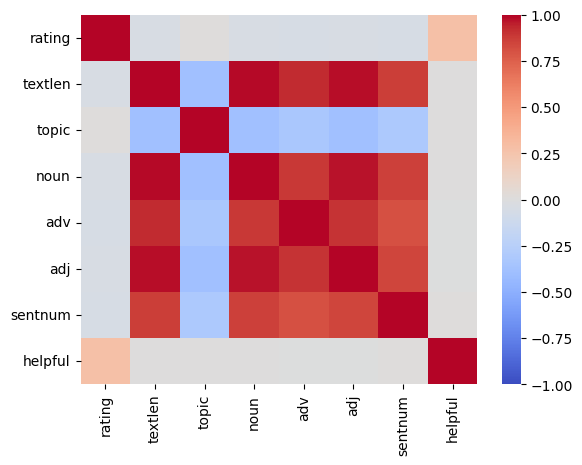

In [28]:
# Heatmap of the numerical data
corr = sample_num.corr()
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1)

In [29]:
# Example of the text data
# Tf-idf vectorizer for the text data
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X_stem)
# give the tfidf exmple with actual words
print('Text Original: '+ X[1]) 
print('Text After Stemed: ' + X_stem [1])
print('Text After Lemmerization: ' + X_lemma [1])
print('Text After Tf-idf on Stemed Text: ')
print(X_tfidf[1])

Text Original: the movie affects you in a way that makes it physically painful to experience but in a good way
Text After Stemed: movi affect way make physic pain experi good way
Text After Lemmerization: movie affect way make physically painful experience good way
Text After Tf-idf on Stemed Text: 
  (0, 9520)	0.21991215830783573
  (0, 7850)	0.36377535527961674
  (0, 16524)	0.3690216011160821
  (0, 17245)	0.4231474051059488
  (0, 13549)	0.2171446029998366
  (0, 24730)	0.48717605999409014
  (0, 1039)	0.45325534448821775
  (0, 14756)	0.11892336032482567


# Different Models for Numerical Features

In [30]:
# Test Train Split
X_num_train, X_num_test, y_num_train, y_num_test = train_test_split(X_num, y_num, test_size=0.2, random_state=42)

In [31]:
# Standardize the numerical data
scaler = StandardScaler()
X_num_train_sd = scaler.fit_transform(X_num_train)
X_num_test_sd = scaler.transform(X_num_test)
# Logistic Regression
logreg = LogisticRegression()
# Hyperparameter tuning use GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'penalty': ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)
logreg_cv.fit(X_num_train_sd, y_num_train)
print(logreg_cv.best_params_)
print(classification_report(y_num_test, logreg_cv.predict(X_num_test_sd)))

{'C': 1, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.60      0.92      0.73      1315
           1       0.46      0.09      0.16       899

    accuracy                           0.59      2214
   macro avg       0.53      0.51      0.44      2214
weighted avg       0.54      0.59      0.50      2214



In [32]:
# Naive Bayes Classifier
# Use hyperparameter tuning with GridSearchCV
nb = MultinomialNB()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
              'fit_prior': [True, False],
              'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6]]}
nb_cv = GridSearchCV(nb, param_grid, cv=10)
nb_cv.fit(X_num_train, y_num_train)
print(nb_cv.best_params_)
print(classification_report(y_num_test, nb_cv.predict(X_num_test)))

{'alpha': 10, 'class_prior': None, 'fit_prior': True}
              precision    recall  f1-score   support

           0       0.67      0.54      0.60      1315
           1       0.48      0.61      0.54       899

    accuracy                           0.57      2214
   macro avg       0.57      0.58      0.57      2214
weighted avg       0.59      0.57      0.57      2214



In [33]:
# Random Forest Classifier
# Use hyperparameter tuning with GridSearchCV
rf = RandomForestClassifier()
param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': [None, 20, 50],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 5]}
rf_cv = GridSearchCV(rf, param_grid, cv=10)
rf_cv.fit(X_num_train_sd, y_num_train)
print(rf_cv.best_params_)
print(classification_report(y_num_test, rf_cv.predict(X_num_test_sd)))

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1315
           1       0.50      0.34      0.40       899

    accuracy                           0.59      2214
   macro avg       0.56      0.55      0.55      2214
weighted avg       0.58      0.59      0.57      2214



In [33]:
# Linear Support Vector Classifier
# Use hyperparameter tuning with GridSearchCV
svc = LinearSVC()
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2']}
svc_cv = GridSearchCV(svc, param_grid, cv=10)
svc_cv.fit(X_num_train_sd, y_num_train)
print(svc_cv.best_params_)
print(classification_report(y_num_test, svc_cv.predict(X_num_test_sd)))

{'C': 1, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.60      0.97      0.74      1315
           1       0.48      0.05      0.08       899

    accuracy                           0.59      2214
   macro avg       0.54      0.51      0.41      2214
weighted avg       0.55      0.59      0.47      2214



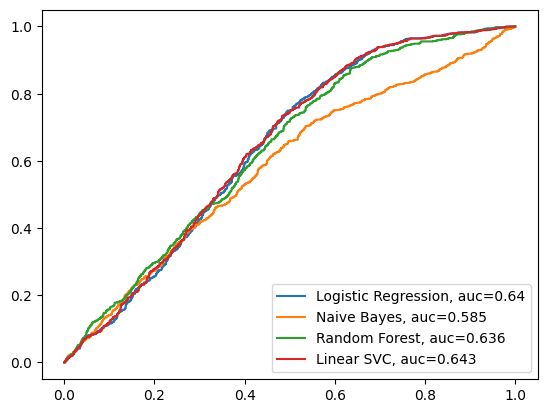

In [34]:
# Draw the ROC curve for all the models with the best hyperparameters
# Logistic Regression
plt.figure(0).clf()
logreg = LogisticRegression(C=0.1, penalty='l2')
logreg.fit(X_num_train_sd, y_num_train)
y_score = logreg.predict_proba(X_num_test_sd)[:, 1]
fpr, tpr, thresh = roc_curve(y_num_test, y_score)
auc = round(roc_auc_score(y_num_test, y_score), 3)
plt.plot(fpr, tpr, label="Logistic Regression, auc="+str(auc))

# Naive Bayes Classifier
nb = MultinomialNB(alpha=10, class_prior=None, fit_prior=True)
nb.fit(X_num_train, y_num_train)
y_score = nb.predict_proba(X_num_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_num_test, y_score)
auc = round(roc_auc_score(y_num_test, y_score), 3)
plt.plot(fpr, tpr, label="Naive Bayes, auc="+str(auc))

# Random Forest Classifier
rf = RandomForestClassifier(max_depth=None, min_samples_leaf=5, min_samples_split=5, n_estimators=100)
rf.fit(X_num_train_sd, y_num_train)
y_score = rf.predict_proba(X_num_test_sd)[:, 1]
fpr, tpr, thresh = roc_curve(y_num_test, y_score)
auc = round(roc_auc_score(y_num_test, y_score), 3)
plt.plot(fpr, tpr, label="Random Forest, auc="+str(auc))

# Linear Support Vector Classifier
svc = LinearSVC(C=1, penalty='l2')
svc.fit(X_num_train_sd, y_num_train)
y_score = svc.decision_function(X_num_test_sd)
fpr, tpr, thresh = roc_curve(y_num_test, y_score)
auc = round(roc_auc_score(y_num_test, y_score), 3)
plt.plot(fpr, tpr, label="Linear SVC, auc="+str(auc))

plt.legend(loc=0)



# Different Models for TF-IDF Features

In [35]:
# Tf-idf vectorizer for the text data
tfidf = TfidfVectorizer()
dtm = tfidf.fit_transform(X_stem)

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(dtm, y_num, test_size=0.2, random_state=42)

In [36]:
# Logistic Regression
logreg = LogisticRegression()
# Hyperparameter tuning use GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2']}
logreg_cv = GridSearchCV(logreg, param_grid, cv=10)
logreg_cv.fit(X_train, y_train)
print(logreg_cv.best_params_)
print(classification_report(y_test, logreg_cv.predict(X_test)))

{'C': 0.01, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.59      1.00      0.75      1315
           1       0.00      0.00      0.00       899

    accuracy                           0.59      2214
   macro avg       0.30      0.50      0.37      2214
weighted avg       0.35      0.59      0.44      2214



In [37]:
# Naive Bayes Classifier
# Use hyperparameter tuning with GridSearchCV
nb = MultinomialNB()
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100],
                'fit_prior': [True, False],
                'class_prior': [None, [0.1, 0.9], [0.2, 0.8], [0.3, 0.7], [0.4, 0.6]]}
nb_cv = GridSearchCV(nb, param_grid, cv=10)
nb_cv.fit(X_train, y_train)
print(nb_cv.best_params_)
print(classification_report(y_test, nb_cv.predict(X_test)))

{'alpha': 1, 'class_prior': None, 'fit_prior': True}
              precision    recall  f1-score   support

           0       0.59      1.00      0.74      1315
           1       0.43      0.00      0.01       899

    accuracy                           0.59      2214
   macro avg       0.51      0.50      0.38      2214
weighted avg       0.53      0.59      0.44      2214



In [40]:
# Random Forest Classifier
# Use hyperparameter tuning with GridSearchCV
rf = RandomForestClassifier()
param_grid = { 'min_samples_split': [5, 10],
                'min_samples_leaf': [2, 5]}
rf_cv = GridSearchCV(rf, param_grid, cv=10)
rf_cv.fit(X_train, y_train)
print(rf_cv.best_params_)
print(classification_report(y_test, rf_cv.predict(X_test)))

{'min_samples_leaf': 5, 'min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.60      0.98      0.74      1315
           1       0.61      0.04      0.08       899

    accuracy                           0.60      2214
   macro avg       0.61      0.51      0.41      2214
weighted avg       0.61      0.60      0.47      2214



In [41]:
# Linear Support Vector Classifier
# Use hyperparameter tuning with GridSearchCV
svc = LinearSVC()
param_grid = {'C': [0.01, 0.1, 1, 10, 100],
                'penalty': ['l1', 'l2']}
svc_cv = GridSearchCV(svc, param_grid, cv=10)
svc_cv.fit(X_train, y_train)
print(svc_cv.best_params_)
print(classification_report(y_test, svc_cv.predict(X_test)))

{'C': 0.01, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       0.59      0.99      0.74      1315
           1       0.18      0.00      0.00       899

    accuracy                           0.59      2214
   macro avg       0.39      0.50      0.37      2214
weighted avg       0.43      0.59      0.44      2214



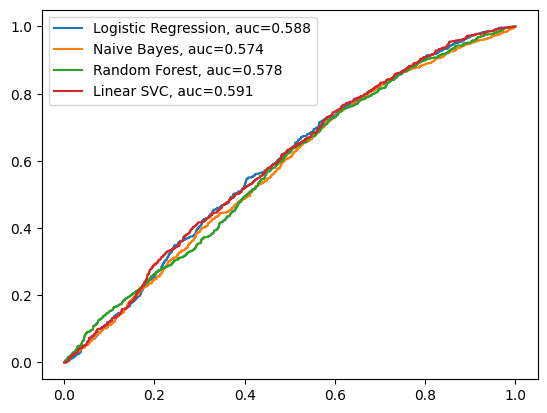

In [42]:
# Draw the ROC curve for all the models with the best hyperparameters
# Logistic Regression
plt.figure(0).clf()
logreg = LogisticRegression(C=0.01, penalty='l2')
logreg.fit(X_train, y_train)
y_score = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, y_score)
auc = round(roc_auc_score(y_test, y_score), 3)
plt.plot(fpr, tpr, label="Logistic Regression, auc="+str(auc))

# Naive Bayes Classifier
nb = MultinomialNB(alpha=1, class_prior=None, fit_prior=True)
nb.fit(X_train, y_train)
y_score = nb.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, y_score)
auc = round(roc_auc_score(y_test, y_score), 3)
plt.plot(fpr, tpr, label="Naive Bayes, auc="+str(auc))

# Random Forest Classifier
rf = RandomForestClassifier(min_samples_leaf=5, min_samples_split=5)
rf.fit(X_train, y_train)
y_score = rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresh = roc_curve(y_test, y_score)
auc = round(roc_auc_score(y_test, y_score), 3)
plt.plot(fpr, tpr, label="Random Forest, auc="+str(auc))

# Linear Support Vector Classifier
svc = LinearSVC(C=0.01, penalty='l2')
svc.fit(X_train, y_train)
y_score = svc.decision_function(X_test)
fpr, tpr, thresh = roc_curve(y_test, y_score)
auc = round(roc_auc_score(y_test, y_score), 3)
plt.plot(fpr, tpr, label="Linear SVC, auc="+str(auc))

plt.legend(loc=0)

# CNN using Keras for Text Classification

In [72]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Embedding

In [73]:
# Create a small dataframe with the text and the label
cnn_df = pd.DataFrame({'text': X_stem, 'label': y_num})

# Test Train Split
X_train, X_test, y_train, y_test = train_test_split(cnn_df['text'], cnn_df['label'], test_size=0.2, random_state=42)


In [74]:
# Find The maximum number of words in a text
maxlen = 0
for text in X_stem:
    if len(text.split()) > maxlen:
        maxlen = len(text.split())

# Find the vocabulary size
vocab_size = len(vectorizer.get_feature_names_out()) + 1

In [75]:
# Use Count Vectorizer to create a document term matrix
vectorizer = CountVectorizer()
vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [76]:
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 915, 100)          2249800   
                                                                 
 conv1d_2 (Conv1D)           (None, 911, 128)          64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
 dense_9 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,315,229
Trainable params: 2,315,229
Non-trainable params: 0
____________________________________________

In [82]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.6049
Testing Accuracy:  0.5939
